# Sentiment Analysis of Tweets with #MaskMandate

In [2]:
#Import the libraries
import tweepy
from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from IPython.display import display
import pandas as pd
import numpy as np
import re
import os
from os import path
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')



In [ ]:
#Get present working directory and read in data with twitter API credentials
pwd =os.getcwd()
twitterlog = pd.read_csv(pwd + '/twitterLogin.csv')
twitterlog

In [4]:
#remove excess whitespace from beginning of  column name and rename
twitterlog.columns = twitterlog.columns.str.lstrip()
#twitterlog.rename(columns = {'comsumerSecret': 'consumerSecret'}, inplace = True)
#twitterlog.columns




In [5]:
twitterlog.dtypes



Key    object
dtype: object

In [6]:
#Get the twitter API credentials
consumerKey = twitterlog['Key'][0]
consumerSecret = twitterlog['Key'][1]
accessToken = twitterlog['Key'][2]
accessTokenSecret = twitterlog['Key'][3]

In [7]:
#Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
#set the acces token and the access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)
#create the API object to fetch tweets
api = tweepy.API(authenticate, wait_on_rate_limit= True)

In [ ]:
#Now I can gather the tweets i'm interested in. 5000 tweets about the mask mandate and fliter out any retweets
search_term = '#maskmandate -filter:retweets'
#create a cursor object
tweets = tweepy.Cursor(api.search_tweets, q=search_term, lang = 'en', since ='2022-03-01', tweet_mode = 'extended').items(5000)
#store the tweets in a variable and get the full text
all_tweets = [tweet.full_text for tweet in tweets]


In [9]:
#Create a dataframe to store the tweets witha column called 'Tweets'
df = pd.DataFrame(all_tweets, columns =['Tweets'])
#show the first 5 rows of data
df.head(20)


Tweets
0   .@Delta Air Lines said it plans to restore fli...
1   Divine intervention right here. \n\nMy heart j...
2   Mask free on the flight!\n\nThe flight attenda...
3   #Covid_19 NOT YET OVER! \n#Maskmandate &amp; #...
4   If the mask mandate was only going to be for t...
5   The time has come for mask mandates to be drop...
6   #maskmandate don't make those poor flight atte...
7   @willnicholas00 @briantylercohen @willnicholas...
8   Hello Everyone,\n1/3) Major mask mandate rever...
9   Sooo… What happened to all the Covid mania? Al...
10  Why do people post pictures of themselves wear...
11  In case you missed The @RitaCosby Show: Rita s...
12  58% think that caller tune of phone/mobile for...
13  Uber driver learns THIS is no longer required ...
14  I dont kno if its the sun or the new #maskmand...
15  If you’re 220 and wearing a mask, I mean… have...
16  @PensivePedsMD @CDCgov @PeoplesCDC .@PeoplesCD...
17  group was founded last year by Manookian, a fo...
18  The real argument...\nAs new rulings and lawsu...
19  Hahahhahahaha\n#maskmandate crushed!\nCheck th...

In [10]:
#Preprocessing of Text
#Create a function to clean the tweets
def cleanTwt(twt):
    twt = re.sub('#maskmandate', 'mask mandate', twt) #removes the '#' from mask mandate
    twt = re.sub('#Maskmandate', 'Mask mandate', twt)
    twt = re.sub('#[A-Za-z0-9]+', '', twt) # removes any string with a '#' using regular expressions
    twt = re.sub('\\n', '', twt) #removes the '\n' string
    twt = re.sub('https?:\/\/\S+','',twt) #removes any hyperlinks
    #twt = re.sub('\w+:\/\/\S+', '',twt)
    return twt
    

In [11]:
#clean the tweets
df['Cleaned_tweets'] = df['Tweets'].apply(cleanTwt)
#Show the cleaned data set
df.head(20)


Tweets  \
0   .@Delta Air Lines said it plans to restore fli...   
1   Divine intervention right here. \n\nMy heart j...   
2   Mask free on the flight!\n\nThe flight attenda...   
3   #Covid_19 NOT YET OVER! \n#Maskmandate &amp; #...   
4   If the mask mandate was only going to be for t...   
5   The time has come for mask mandates to be drop...   
6   #maskmandate don't make those poor flight atte...   
7   @willnicholas00 @briantylercohen @willnicholas...   
8   Hello Everyone,\n1/3) Major mask mandate rever...   
9   Sooo… What happened to all the Covid mania? Al...   
10  Why do people post pictures of themselves wear...   
11  In case you missed The @RitaCosby Show: Rita s...   
12  58% think that caller tune of phone/mobile for...   
13  Uber driver learns THIS is no longer required ...   
14  I dont kno if its the sun or the new #maskmand...   
15  If you’re 220 and wearing a mask, I mean… have...   
16  @PensivePedsMD @CDCgov @PeoplesCDC .@PeoplesCD...   
17  group was founded last year by Manookian, a fo...   
18  The real argument...\nAs new rulings and lawsu...   
19  Hahahhahahaha\n#maskmandate crushed!\nCheck th...   

                                       Cleaned_tweets  
0   .@Delta Air Lines said it plans to restore fli...  
1   Divine intervention right here. My heart jumpe...  
2   Mask free on the flight!The flight attendant j...  
3   _19 NOT YET OVER! Mask mandate &amp;  are cruc...  
4   If the mask mandate was only going to be for t...  
5   The time has come for mask mandates to be drop...  
6   mask mandate don't make those poor flight atte...  
7   @willnicholas00 @briantylercohen @willnicholas...  
8   Hello Everyone,1/3) Major mask mandate reversa...  
9   Sooo… What happened to all the Covid mania? Al...  
10  Why do people post pictures of themselves wear...  
11  In case you missed The @RitaCosby Show: Rita s...  
12  58% think that caller tune of phone/mobile for...  
13  Uber driver learns THIS is no longer required ...  
14  I dont kno if its the sun or the new mask mand...  
15  If you’re 220 and wearing a mask, I mean… have...  
16  @PensivePedsMD @CDCgov @PeoplesCDC .@PeoplesCD...  
17  group was founded last year by Manookian, a fo...  
18  The real argument...As new rulings and lawsuit...  
19  Hahahhahahahamask mandate crushed!Check the Ge...

In [12]:
#create a function to get the subjectivity
def getSubjectivity (twt):
    return TextBlob(twt).sentiment.subjectivity
#create a function to get the polarity
def getPolarity(twt):
    return TextBlob(twt).sentiment.polarity

#Create two new columns called subjectivity and Polarity
df['Subjectivity']= df['Cleaned_tweets'].apply(getSubjectivity)
df['Polarity']= df['Cleaned_tweets'].apply(getPolarity)

#show the data
df.tail(20)

Tweets  \
4980  the #maskmandate was struck down by someone wh...   
4981  Imagine all the people that even once thought ...   
4982  Is there a judge that could end the #maskmanda...   
4983  I’ve never seen so many happy white people sin...   
4984  The covid cult is very upset. Not only are san...   
4985  Not looking forward to going back to the days ...   
4986  Buy now\n⬇️\nhttps://t.co/aGUU9Kf9Ur\nTop U-Ne...   
4987  P.S. how does lifting the #maskmandate “facili...   
4988  Even knowing the #maskmandate for planes and t...   
4989  @denise_dewald #maskmandate or demand a refund...   
4990  #maskmandate America is under attack by a biol...   
4991  How many people will die or suffer long-term c...   
4992                               #maskmandate Mondays   
4993  @MonicaCrowley This is what gives you joy? I’m...   
4994  @RonFilipkowski Go figure. #maskmandate #Clare...   
4995  Christian Right on Sunday, "Jesus died for me!...   
4996  Now only small private businesses will have #m...   
4997  I’m so fucking pissed about this. Why does thi...   
4998  Strange ruling: @CDCgov doesn't have the autho...   
4999  While some are celebrating the end of mask man...   

                                         Cleaned_tweets  Subjectivity  \
4980  the mask mandate was struck down by someone wh...      0.394444   
4981  Imagine all the people that even once thought ...      0.369444   
4982  Is there a judge that could end the mask manda...      0.000000   
4983  I’ve never seen so many happy white people sin...      0.500000   
4984  The covid cult is very upset. Not only are san...      0.500000   
4985  Not looking forward to going back to the days ...      0.430612   
4986  Buy now⬇️ U-Neck Bottoming Shirt Stretch Short...      0.300000   
4987  P.S. how does lifting the mask mandate “facili...      0.218750   
4988  Even knowing the mask mandate for planes and t...      0.600000   
4989  @denise_dewald mask mandate or demand a refund...      0.000000   
4990  mask mandate America is under attack by a biol...      0.100000   
4991  How many people will die or suffer long-term c...      0.465000   
4992                               mask mandate Mondays      0.000000   
4993  @MonicaCrowley This is what gives you joy? I’m...      0.600000   
4994           @RonFilipkowski Go figure. mask mandate       0.000000   
4995  Christian Right on Sunday, "Jesus died for me!...      0.317460   
4996  Now only small private businesses will have ma...      0.591667   
4997  I’m so fucking pissed about this. Why does thi...      0.800000   
4998  Strange ruling: @CDCgov doesn't have the autho...      0.266667   
4999  While some are celebrating the end of mask man...      0.000000   

      Polarity  
4980 -0.077778  
4981  0.072222  
4982  0.000000  
4983  0.433333  
4984 -0.033333  
4985 -0.146939  
4986 -0.100000  
4987  0.093750  
4988 -0.233333  
4989  0.000000  
4990  0.000000  
4991  0.340000  
4992  0.000000  
4993  0.150000  
4994  0.000000  
4995  0.133929  
4996 -0.083333  
4997 -0.600000  
4998  0.062500  
4999  0.000000

In [13]:
#create a function to get the sentiment text
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [14]:
#Create a column to store the text sentiment
df['Sentiment'] = df['Polarity'].apply(getSentiment)
#show the data
df.head(20)

Tweets  \
0   .@Delta Air Lines said it plans to restore fli...   
1   Divine intervention right here. \n\nMy heart j...   
2   Mask free on the flight!\n\nThe flight attenda...   
3   #Covid_19 NOT YET OVER! \n#Maskmandate &amp; #...   
4   If the mask mandate was only going to be for t...   
5   The time has come for mask mandates to be drop...   
6   #maskmandate don't make those poor flight atte...   
7   @willnicholas00 @briantylercohen @willnicholas...   
8   Hello Everyone,\n1/3) Major mask mandate rever...   
9   Sooo… What happened to all the Covid mania? Al...   
10  Why do people post pictures of themselves wear...   
11  In case you missed The @RitaCosby Show: Rita s...   
12  58% think that caller tune of phone/mobile for...   
13  Uber driver learns THIS is no longer required ...   
14  I dont kno if its the sun or the new #maskmand...   
15  If you’re 220 and wearing a mask, I mean… have...   
16  @PensivePedsMD @CDCgov @PeoplesCDC .@PeoplesCD...   
17  group was founded last year by Manookian, a fo...   
18  The real argument...\nAs new rulings and lawsu...   
19  Hahahhahahaha\n#maskmandate crushed!\nCheck th...   

                                       Cleaned_tweets  Subjectivity  Polarity  \
0   .@Delta Air Lines said it plans to restore fli...      0.000000  0.000000   
1   Divine intervention right here. My heart jumpe...      0.367857  0.542857   
2   Mask free on the flight!The flight attendant j...      0.750000  0.125000   
3   _19 NOT YET OVER! Mask mandate &amp;  are cruc...      0.900000  0.000000   
4   If the mask mandate was only going to be for t...      0.666667  0.262500   
5   The time has come for mask mandates to be drop...      0.450000  0.250000   
6   mask mandate don't make those poor flight atte...      0.550000 -0.200000   
7   @willnicholas00 @briantylercohen @willnicholas...      0.500000  0.500000   
8   Hello Everyone,1/3) Major mask mandate reversa...      0.500000  0.062500   
9   Sooo… What happened to all the Covid mania? Al...      0.281250 -0.125000   
10  Why do people post pictures of themselves wear...      0.000000  0.000000   
11  In case you missed The @RitaCosby Show: Rita s...      0.787500 -0.218750   
12  58% think that caller tune of phone/mobile for...      0.500000  0.500000   
13  Uber driver learns THIS is no longer required ...      0.000000  0.000000   
14  I dont kno if its the sun or the new mask mand...      0.538636 -0.015909   
15  If you’re 220 and wearing a mask, I mean… have...      0.000000  0.000000   
16  @PensivePedsMD @CDCgov @PeoplesCDC .@PeoplesCD...      0.066667  0.000000   
17  group was founded last year by Manookian, a fo...      0.055556  0.033333   
18  The real argument...As new rulings and lawsuit...      0.318182  0.178788   
19  Hahahhahahahamask mandate crushed!Check the Ge...      0.400000 -0.050000   

   Sentiment  
0    Neutral  
1   Positive  
2   Positive  
3    Neutral  
4   Positive  
5   Positive  
6   Negative  
7   Positive  
8   Positive  
9   Negative  
10   Neutral  
11  Negative  
12  Positive  
13   Neutral  
14  Negative  
15   Neutral  
16   Neutral  
17  Positive  
18  Positive  
19  Negative

In [15]:
#checking that i have 5000 tweets
df.shape[0]

5000

In [59]:
#group by sentiment type
no_sentiment = df[['Sentiment', 'Tweets']]
Sentiment_type = no_sentiment.groupby('Sentiment').agg('count')
Sentiment_type 
len(df['Tweets'])

5000

In [55]:
def percentage(part, whole):
  return 100 * float(part)/float(whole)

negative_no = Sentiment_type['Tweets'][0]
neutral_no = Sentiment_type['Tweets'][1]
positive_no = Sentiment_type['Tweets'][2]


2017

In [72]:
positive = percentage(positive_no, len(df['Tweets']))
negative = percentage(negative_no, len(df['Tweets']))
neutral = percentage(neutral_no, len(df['Tweets']))
 
print( '{} ({}) % of tweets include positive sentiment'.format(positive_no,positive))
print( '{} ({}) % of tweets include positive sentiment'.format(negative_no,negative))
print( '{} ({}) % of tweets include positive sentiment'.format(neutral_no, neutral))

2017 (40.34) % of tweets include positive sentiment
1250 (25.0) % of tweets include positive sentiment
1733 (34.66) % of tweets include positive sentiment


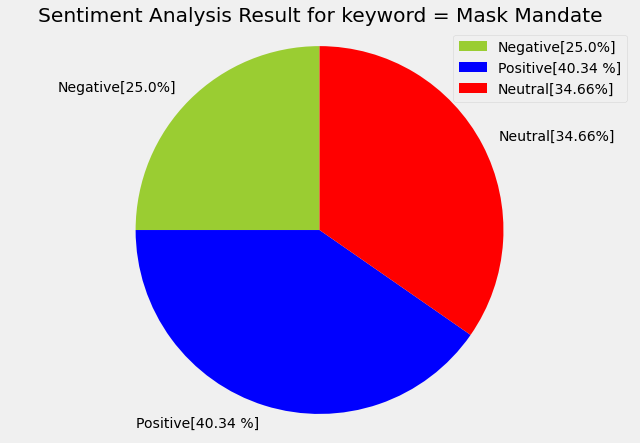

In [90]:
#Create a piec chart
Sentiment = ['Negative['+str(negative)+'%]', 'Positive['+str(positive)+' %]', 'Neutral['+str(neutral)+'%]']
sizes = [negative, positive, neutral]
colors = ['Yellowgreen', 'blue', 'red']
plt.figure(figsize=(10,7))
plt.pie(sizes, labels = Sentiment, colors= colors, startangle=90)
plt.title('Sentiment Analysis Result for keyword = Mask Mandate')
plt.axis('equal')
plt.legend(Sentiment)
plt.show()

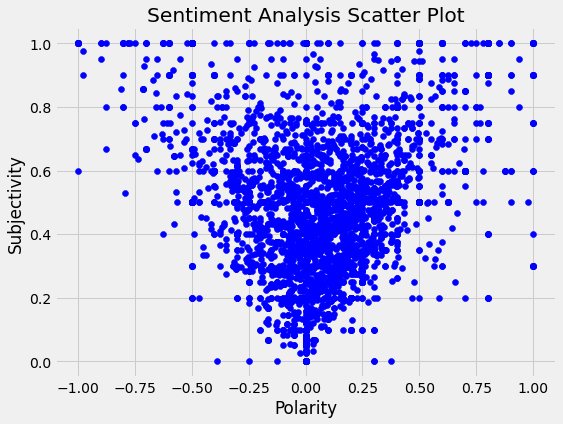

In [92]:
#create a scatter plot to show the subjectivity and the polarity
plt.figure(figsize =(8,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i],color = 'Blue')
plt.title('Sentiment Analysis Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

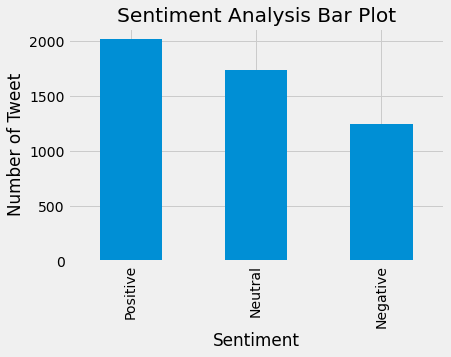

In [137]:
#Create a bar chart to show the count of Positive, Neutral, and Negative sentiments
df['Sentiment'].value_counts().plot(kind ='bar')
plt.title('Sentiment Analysis Bar Plot')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweet')
plt.show()

In [125]:
#Function to create world cloud
def create_wordcloud(text):
 mask = np.array(Image.open(path.join(pwd,'comment.png')))
 stopwords = set(STOPWORDS)
 #create world cloud object
 wc = WordCloud(background_color='white',
 mask = mask,
 max_words=5000,
 stopwords=stopwords,
 repeat=True)
 wc.generate(str(text))
 #save world cloud
 wc.to_file(path.join(pwd,'wc.png'))
 print('Word Cloud Saved Successfully')
 display(Image.open(path.join(pwd, 'wc.png')))


Word Cloud Saved Successfully


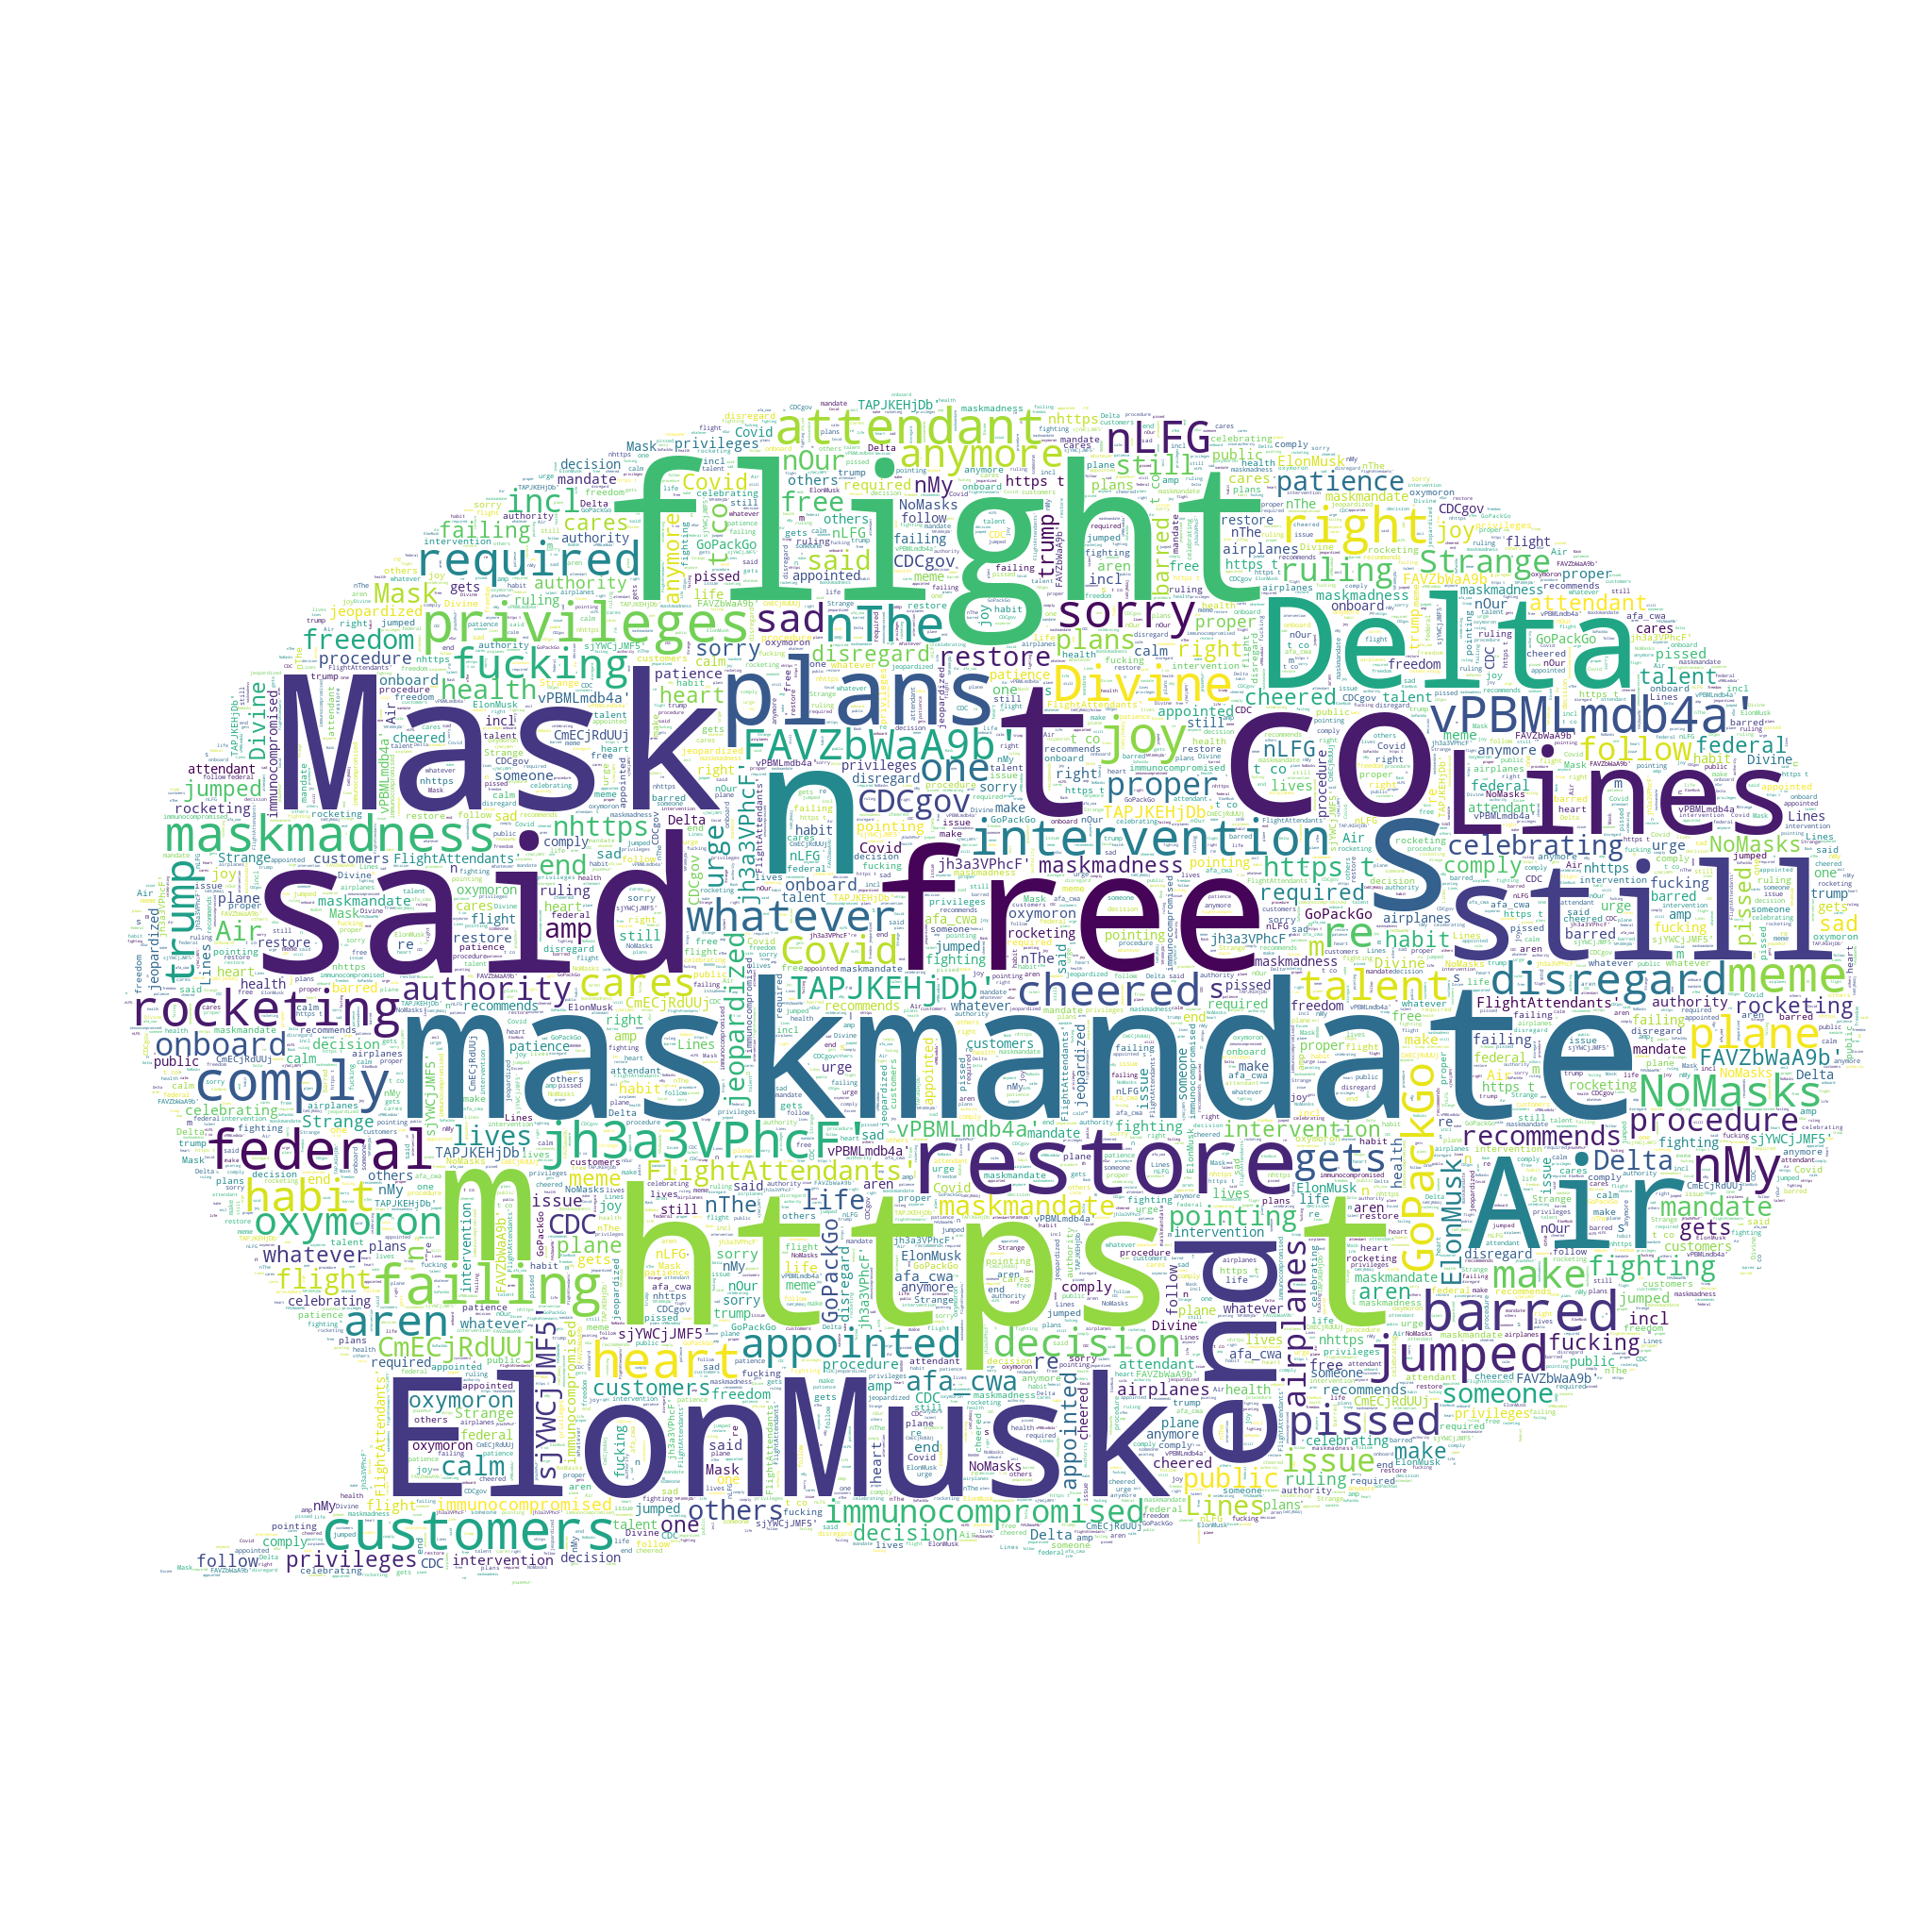

In [124]:
#Creating wordcloud for all tweets
create_wordcloud(df['Tweets'].values)

In [130]:
positive_tweets= df[df['Sentiment']=='Positive']
negative_tweets= df[df['Sentiment']=='Negative']
neutral_tweets= df[df['Sentiment']=='Neutral']


Tweets  \
6     #maskmandate don't make those poor flight atte...   
9     Sooo… What happened to all the Covid mania? Al...   
11    In case you missed The @RitaCosby Show: Rita s...   
14    I dont kno if its the sun or the new #maskmand...   
19    Hahahhahahaha\n#maskmandate crushed!\nCheck th...   
...                                                 ...   
4985  Not looking forward to going back to the days ...   
4986  Buy now\n⬇️\nhttps://t.co/aGUU9Kf9Ur\nTop U-Ne...   
4988  Even knowing the #maskmandate for planes and t...   
4996  Now only small private businesses will have #m...   
4997  I’m so fucking pissed about this. Why does thi...   

                                         Cleaned_tweets  Subjectivity  \
6     mask mandate don't make those poor flight atte...      0.550000   
9     Sooo… What happened to all the Covid mania? Al...      0.281250   
11    In case you missed The @RitaCosby Show: Rita s...      0.787500   
14    I dont kno if its the sun or the new mask mand...      0.538636   
19    Hahahhahahahamask mandate crushed!Check the Ge...      0.400000   
...                                                 ...           ...   
4985  Not looking forward to going back to the days ...      0.430612   
4986  Buy now⬇️ U-Neck Bottoming Shirt Stretch Short...      0.300000   
4988  Even knowing the mask mandate for planes and t...      0.600000   
4996  Now only small private businesses will have ma...      0.591667   
4997  I’m so fucking pissed about this. Why does thi...      0.800000   

      Polarity Sentiment  
6    -0.200000  Negative  
9    -0.125000  Negative  
11   -0.218750  Negative  
14   -0.015909  Negative  
19   -0.050000  Negative  
...        ...       ...  
4985 -0.146939  Negative  
4986 -0.100000  Negative  
4988 -0.233333  Negative  
4996 -0.083333  Negative  
4997 -0.600000  Negative  

[1250 rows x 5 columns]

Word Cloud Saved Successfully


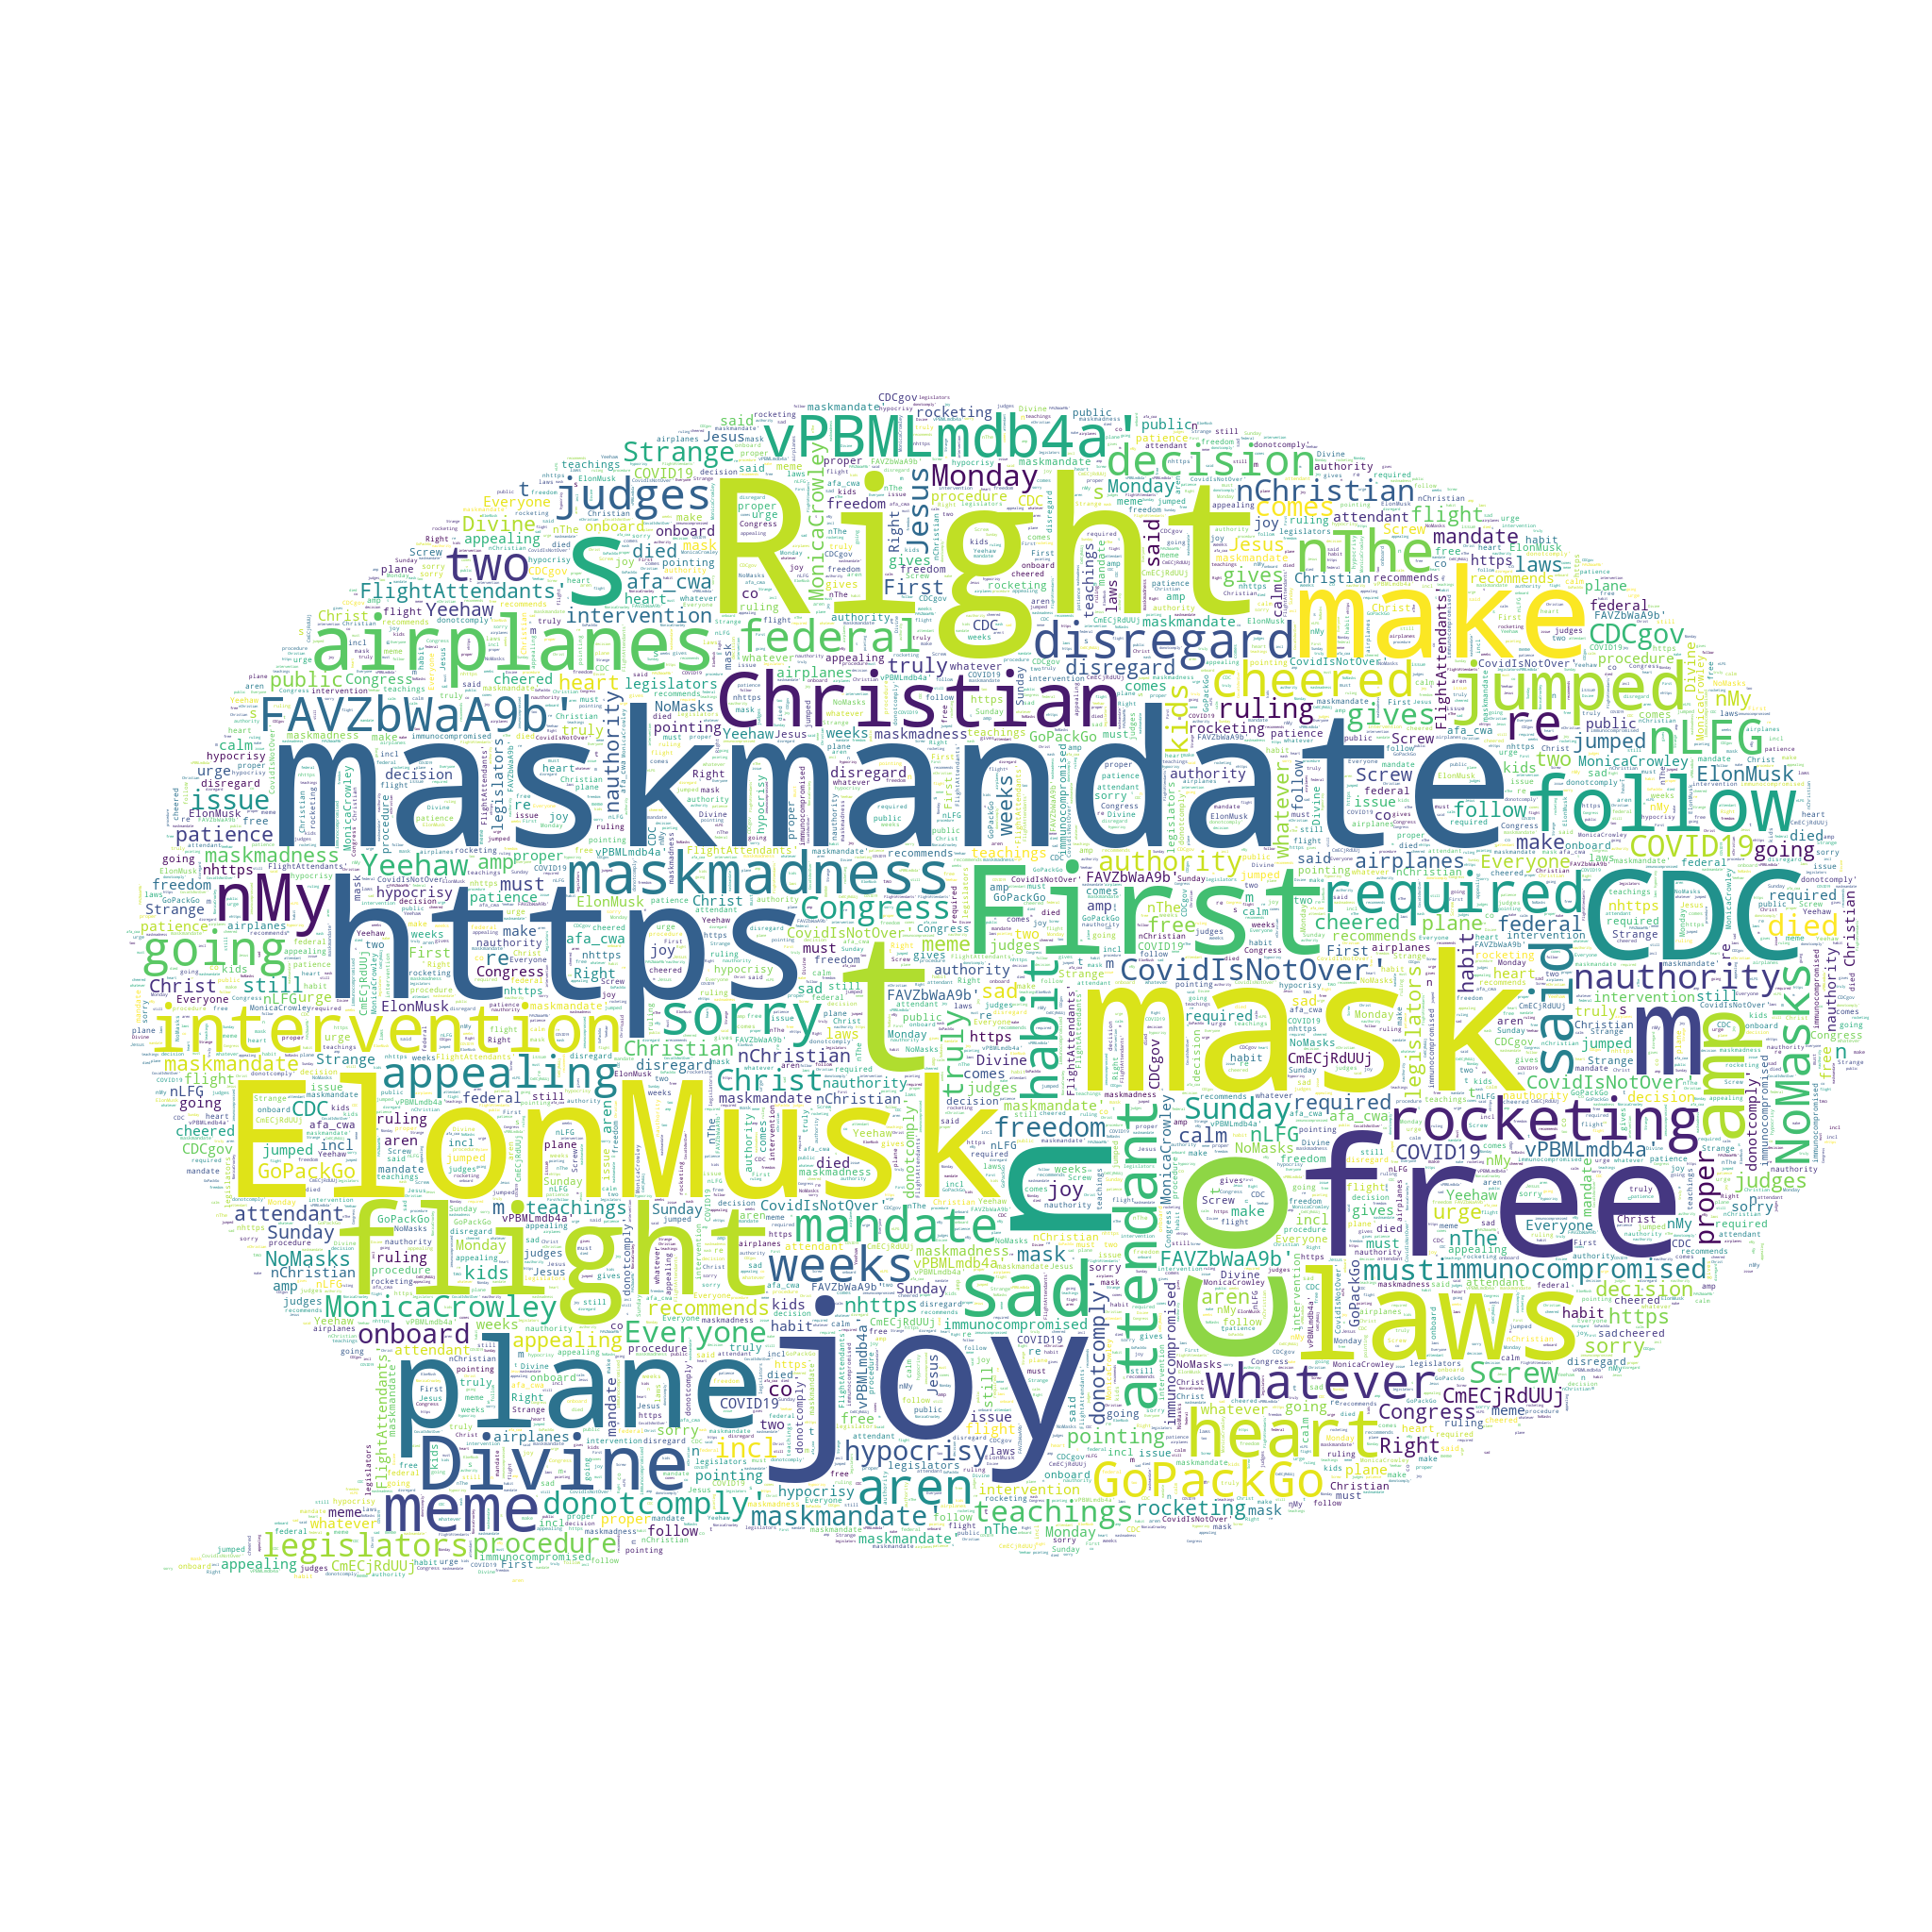

In [131]:
#create worldcloud for positive sentiment
create_wordcloud(positive_tweets['Tweets'].values)



Word Cloud Saved Successfully


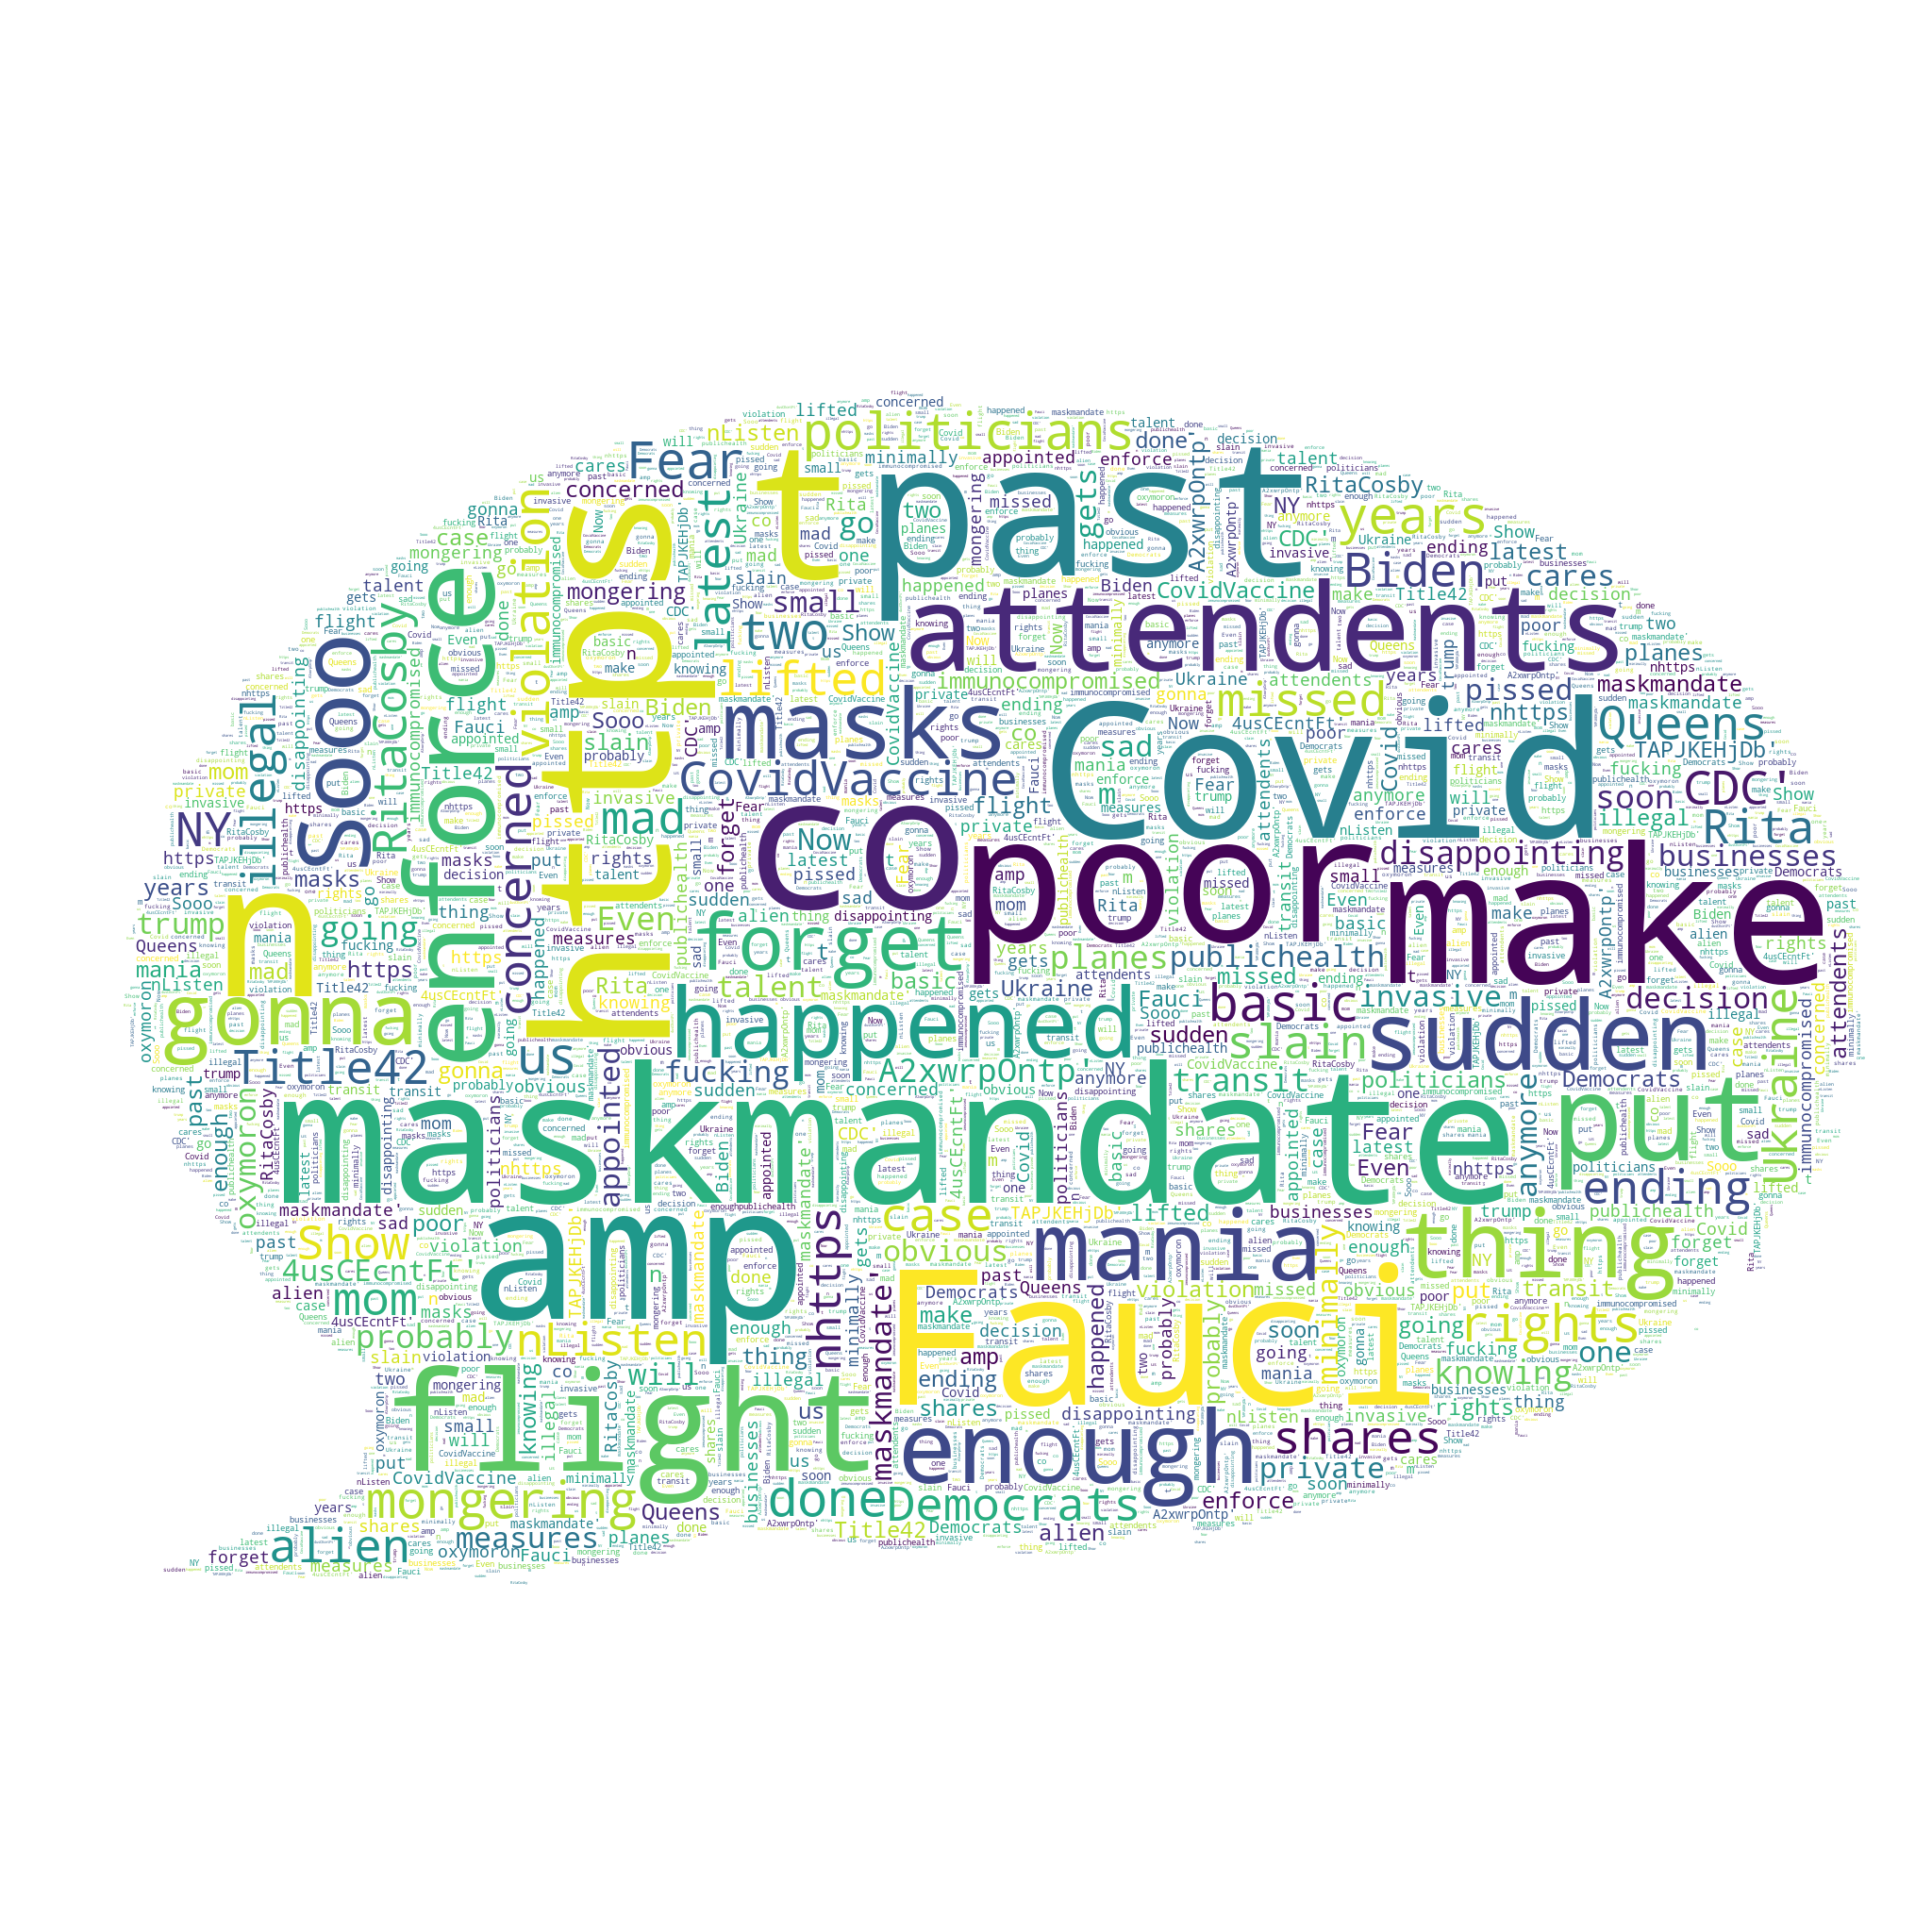

In [132]:
#create worldcloud for negative sentiment
create_wordcloud(negative_tweets['Tweets'].values)

Word Cloud Saved Successfully


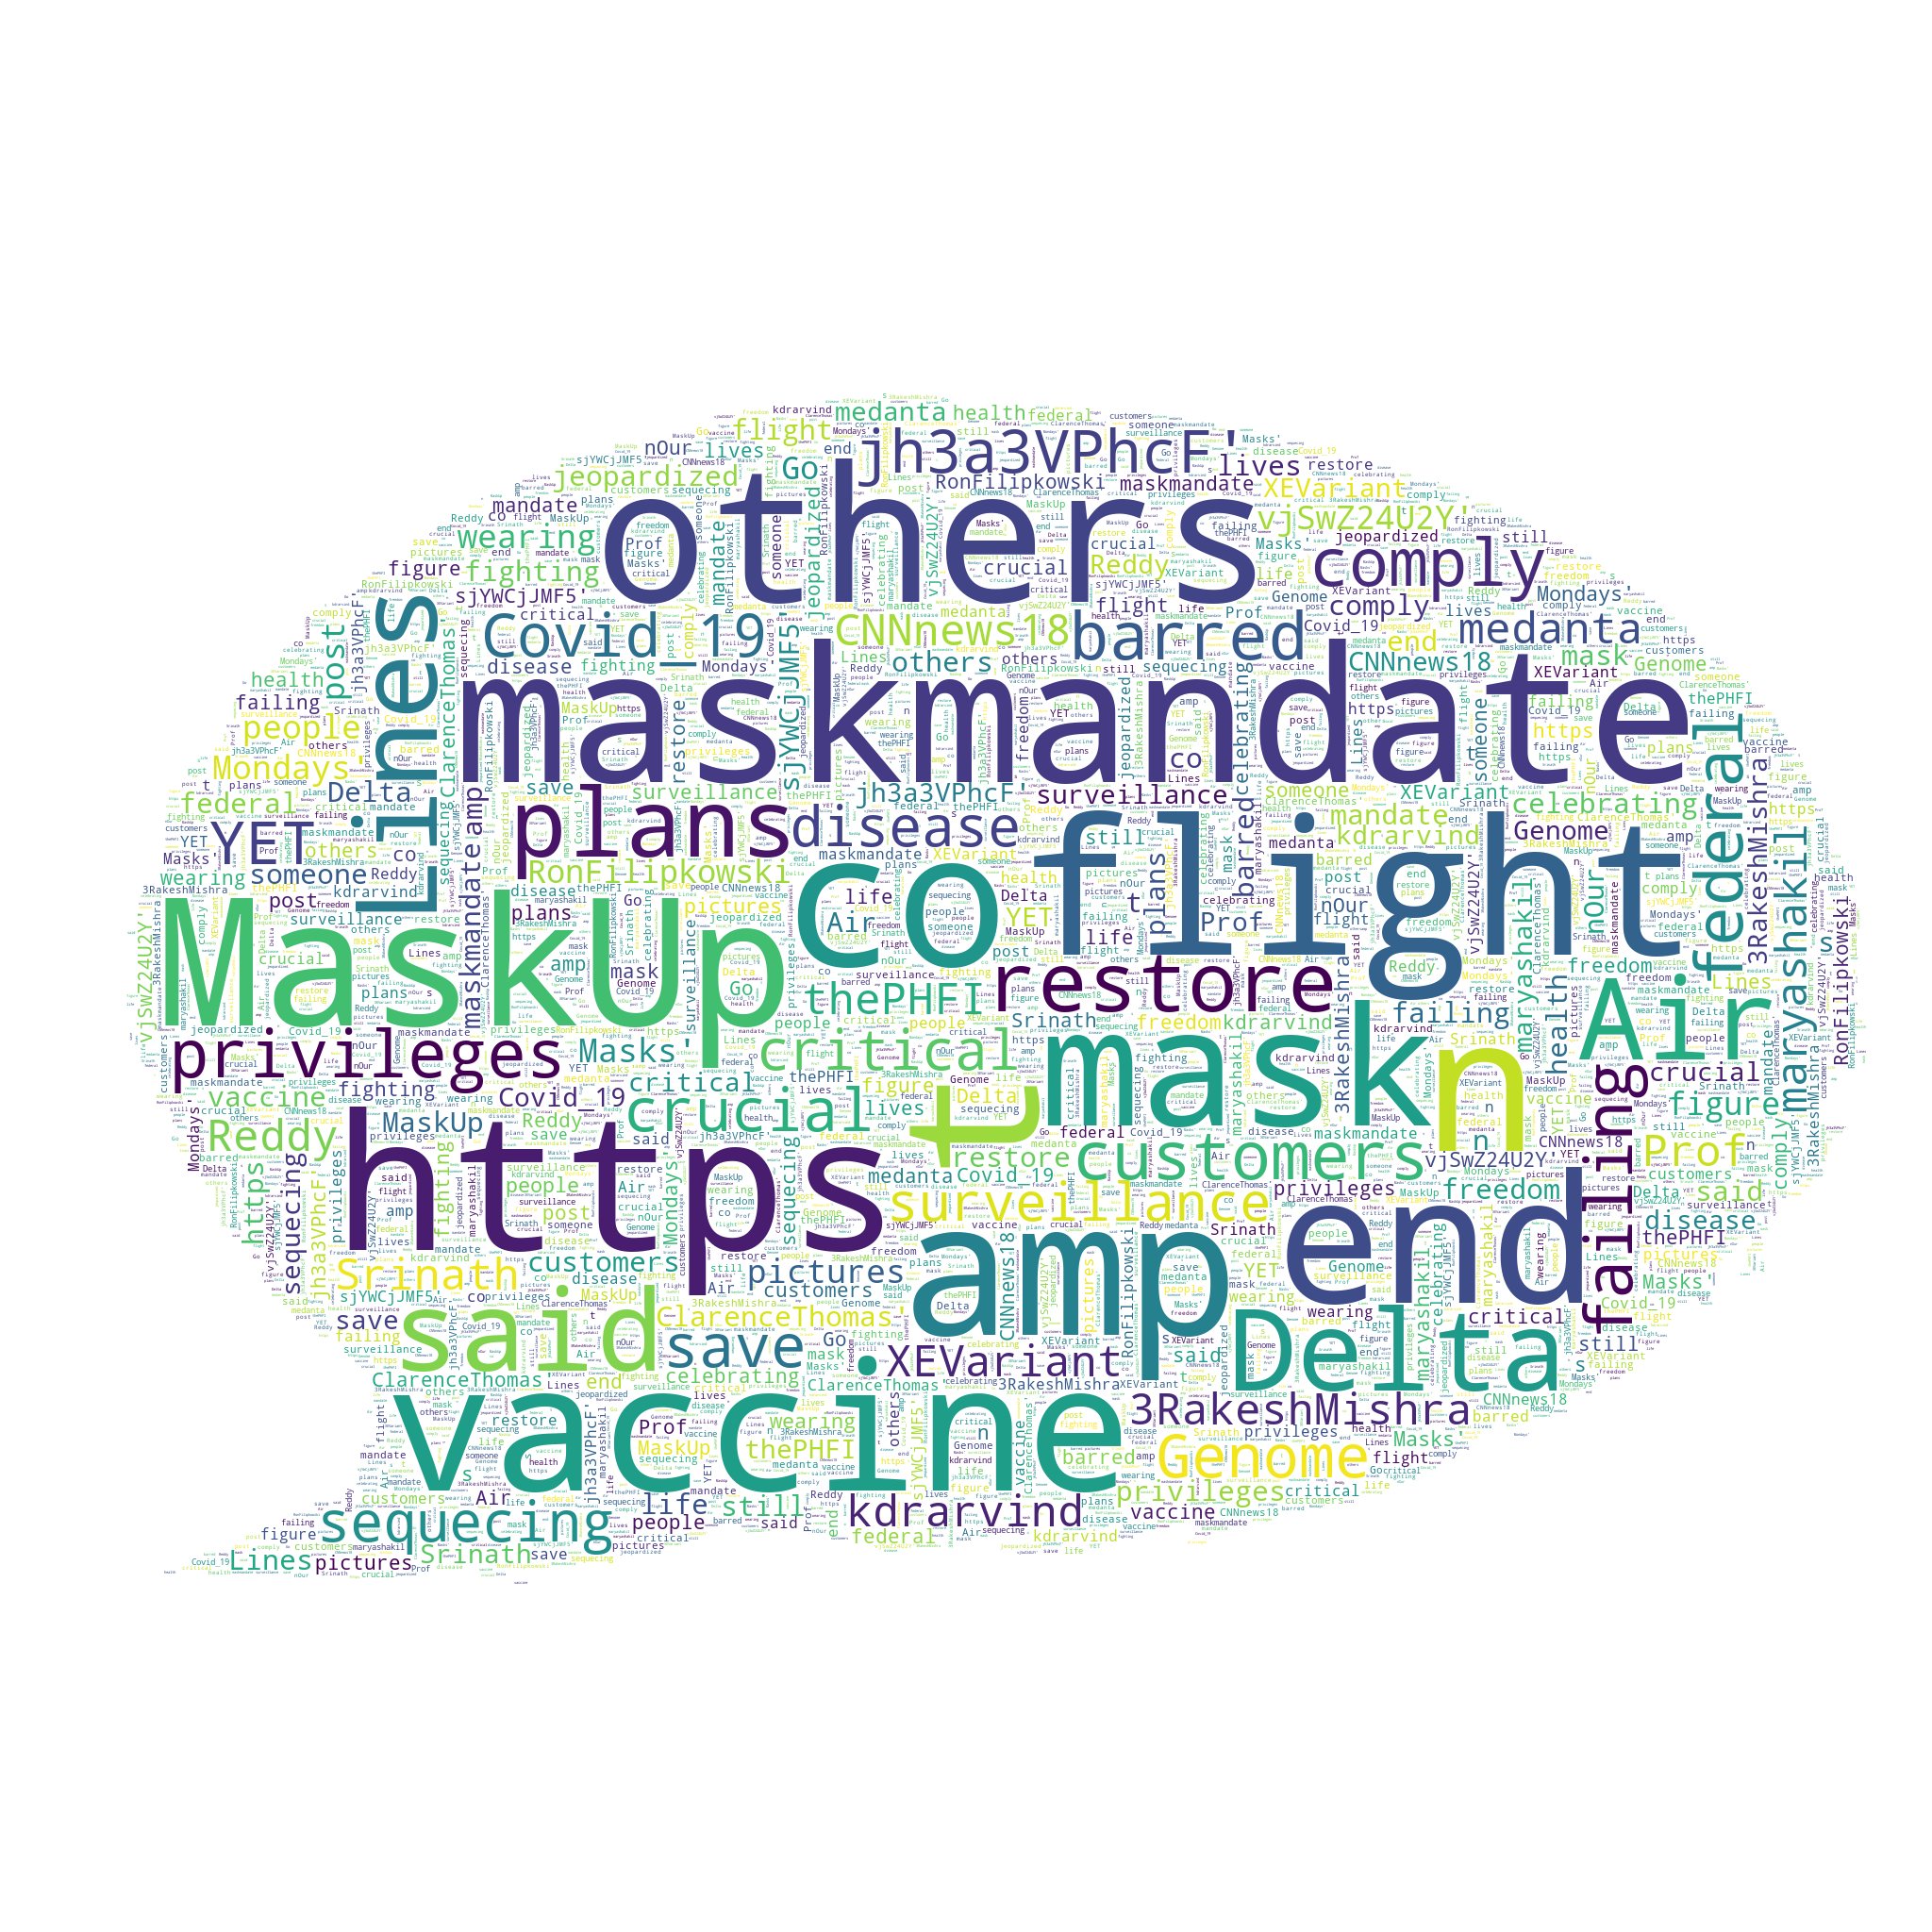

In [133]:
#create worldcloud for neutral sentiment
create_wordcloud(neutral_tweets['Tweets'].values)